# EXAMPLES

In this Jupyter Notebook we provide three examples which should clarify how to use the scripts in this repository to compute the RSE distance and delta_g. The three examples are summarized as follows:
* The first example illustrates how to compute the RSE distance between two specific vertices in a network
* The second example illustrates how to compute the RSE distance between multiple vertices in a network. It is self contained, but we strongly suggest to look at Example 1 first
* The third example illustrates how to compute the structural diversity index Delta(G) for a network G. Also this example is self contained, but again we strongly suggest to look at Example 1 first

Have fun!

## DISCLAIMER: CUDA vs NOT CUDA
All the examples below use the version the RandomWalkSimulator which does NOT require CUDA. \
However, the version which uses CUDA (which is much faster) has exactly the same syntax.  \
Therefore, on can use this tutorial in identical fashion. It suffices to import RandomWalkSimulator from the file RandomWalksSimulatorCUDA.py

### IMPORTS
Here we import the packages required for the examples

In [1]:
# We import graph_tool in order to feed the RandomWalksSimulator a graph for which we want to compute the RSE distance 
import graph_tool.all as gt


(ipykernel_launcher.py:27213): Gtk-WARNING **: 17:50:34.289: Locale not supported by C library.
	Using the fallback 'C' locale.


Below, if you want to use cuda you can erase the replace the import statement with the import statement preceded by two hashtags below

In [2]:
# We import the class RandomWalksSimulator inside the script RandomWalkSimulator
from RandomWalkSimulator import RandomWalkSimulator

# USE THIS IMPORT STATEMENT FOR CUDA VERSION
## from RandomWalkSimulatorCUDA import RandomWalkSimulator

In [3]:
# We import the MeetingTimeEstimator
from MeetingTimeEstimator import MeetingTimeEstimator

In [4]:
# We import color maps form matplotlib in order to make nice visualizations
from matplotlib import cm
# We import numpy 
import numpy as np

## EXAMPLE 1: COMPUTING THE RSE DISTANCE BETWEEN TWO VERTICES i AND j

In this example we compute the RSE distance between two fixed vertices i and j

### STEP 1: NETWORK
We build a network modelling our population and select two vertices i and j for which we want to know the RSE distance.

In [5]:
# We build a scale-free network with 100 nodes, minimal degree 2 and exponent gamma equal to 3
g = gt.price_network(N=100, m=2, gamma=1, directed=False)

In [6]:
# We fix the index of our two vertices i and j 
i = 1
j = 3

Below we draw the network to help you visualize what it looks like

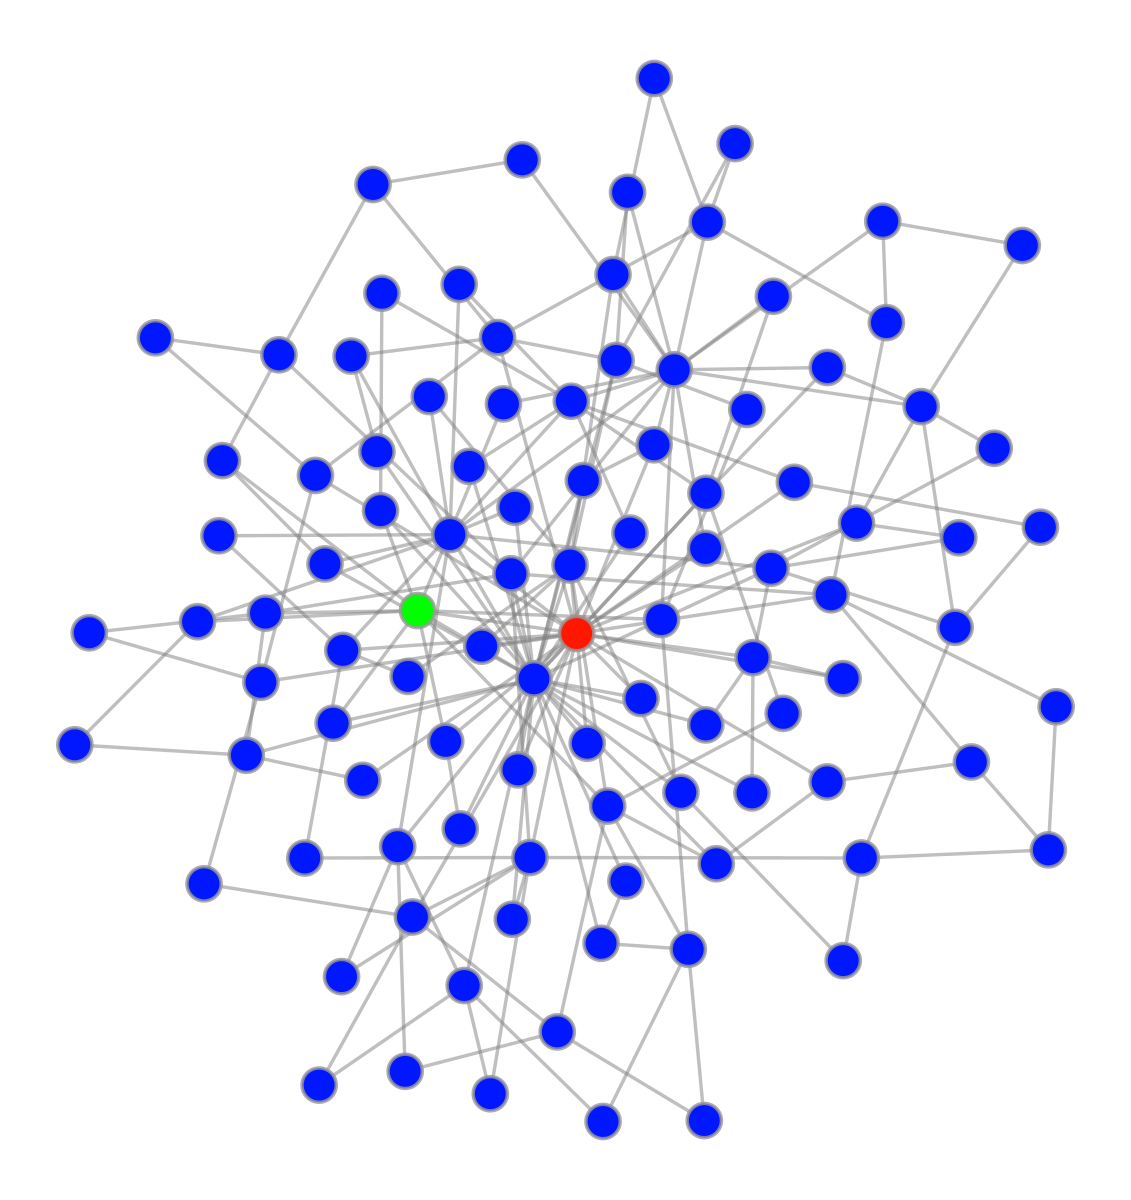

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9eea9a4670, at 0x7f9ee5f7b4f0>

In [7]:
# Code to draw the network

# This code is to color the vertices of our graph

cmap = cm.get_cmap('gist_rainbow') # Color map
color_i = cmap(0.05) # Red
color_j = cmap(0.4) # Green
color_others = cmap(0.75) # Blue

colors_vertices = []
for k in g.get_vertices():
    if k == i:
        colors_vertices.append(color_i)
    elif k == j:
        colors_vertices.append(color_j)
    else:
        colors_vertices.append(color_others)

# This code is to color the edges
edge_color = [0.5, 0.5, 0.5, 0.5] # Grey

# This code draws the graph
gt.graph_draw(g, vprops={'fill_color': g.new_vertex_property('vector<float>', vals=colors_vertices)}, eprops={'color': g.new_edge_property('vector<float>', val=edge_color)})

### STEP 2: COMPUTE THE AVERAGE MEETING TIME OF THE RANDOM WALKS STARTED AT i AND j
We compute several samples of the meeting time between the random walk started at i and the random walk started at j using the RandomWalkSimulator.

In [8]:
# Initialize a RandomWalkSimulator on the network g
rws = RandomWalkSimulator(g=g)

In order to compute samples of the meeting time of the random walk started at i and the random walk started at j we need to feed the following information to the method **get_meeting_times_rse_dist** of the RandomWalkSimulator:
* The vertices i and j for which we want to compute the samples
* The number of samples of the meeting time we want the method to return. The more samples the more accurate will our estimate of the average meeting time be. 
* The maximum number of steps for which we want to simulate the random walks in order to get one sample of the meeting time. The simulation will stop after running for this number of time steps. It could stop earlier if all the walks meet in less time steps.

With these parameters we can launch the method **get_meeting_times_rse_dist**. This method returns us a dictionary with keys being pairs of vertices and values being an array with samples of the meeting time between those two vertices.

In [9]:
# The vertices for which we wan the samples
vertices = [i,j]

# The number of meeting time samples we want
n_samples_per_vertex = 50

# The maximum number of steps of the simulation
max_time_steps = 1000

# We call the method get_meeting_times with the above parameters
meeting_times = rws.get_meeting_times_rse_dist(max_time_steps=max_time_steps, vertices=vertices, n_samples_per_vertex=n_samples_per_vertex)

# We display the meeting time dictionary (see the remarks below)
meeting_times

 47%|████▋     | 473/999 [00:00<00:00, 1360.02it/s]


{(1, 3): array([23., 31.,  8., ...,  9., 10., 41.]),
 (3, 1): array([ 23.,  12.,   7., ..., 159.,   9.,  41.])}

Some remarks on the dictionary meeting_times:
* It is a dictionary where the keys are pairs of vertices and the values are arrays containing samples of the meeting time of the walks started at that pair of vertices
* Occasionaly you might see an entry equal to -1 in the array. This happens when the walks corresponding to one sample did not meet within mex_time_steps. See below for comments on this issue

### WHAT TO DO IN CASE YOU HAVE SOME -1 IN THE MEETING TIME ARRAY

If, for some array of meeting time sample some entry is equal to -1, it means that the random walks which we simulated to compute that meeting time sample did not meet within max_time_steps. To solve this problem one can:
* Rerun the simulation increasing max_time_steps and hope that all walks will meet. The bounds in the paper could help estimate max_time_steps
* Use the class MeetingTimeEstimator as illustrated below. 

The class MeetingTimeEstimator implements some methods that allow to estimate the value of a meeting time sample, given that the walks simulated to compute that sample did not meet.
The main idea behind these methods is to use the fact that meeting times are approximately geometrically distributed

In [10]:
# Extract the meeting time array of i and j from the dictionary
arr_meeting_time_ij = meeting_times[(i,j)]

# Use the estimator to estimate the samples for the walks that did not meet. 
# Essentially this replaces the -1 by an estimate of what the value should be.
meeting_times_ij_estimate = MeetingTimeEstimator.estimate_meeting_times_unmet_random_walks(meeting_times=arr_meeting_time_ij, max_time_steps=max_time_steps)
meeting_times_ij_estimate

array([23., 31.,  8., ...,  9., 10., 41.])

### STEP 3: COMPUTE THE RSE DISTANCE

We compute the RSE distance between i and j by using the meeting times computed in step 2. This is simply acheived by taking the mean of these meeting times. \
Here we use meeting_times_ij_estimate because we want to get rid of values equal to -1.

In [11]:
# To compute the RSE distance we simply average over the meeting times of i and j
rse_dist_ij = np.mean(meeting_times_ij_estimate)

# We may also be interested in the std in order to compute confidence intervals 
std_rse_dist_ij = np.std(meeting_times_ij_estimate)

Finally here are our results:

In [12]:
print('The RSE distance between i and j is', rse_dist_ij, 'with 95 percent confidence intervals of size', 1.96*std_rse_dist_ij/np.sqrt(n_samples_per_vertex))

The RSE distance between i and j is 59.8632 with 95 percent confidence intervals of size 16.82340624564218


## EXAMPLE 2: COMPUTING THE RSE DISTANCE OF A RANDOM SAMPLE OF VERTICES

In this example we sample a set S of 4 vertices randomly from the network and compute the RSE distance between every possible pair of these four vertices

### STEP 1: SAMPLING THE VERTICES
For confort we reuse the network g created in the previous example. We sample a set S of 4 vertices form the network g.

In [13]:
# We sample the a set S of vertices from the network g
sample_size = 4
S = np.random.choice(g.get_vertices(), size=sample_size, replace=False)
S

array([10, 88, 93, 84])

Below we draw the network highlighting the sampled vertices to help you visualize which vertices we are considering

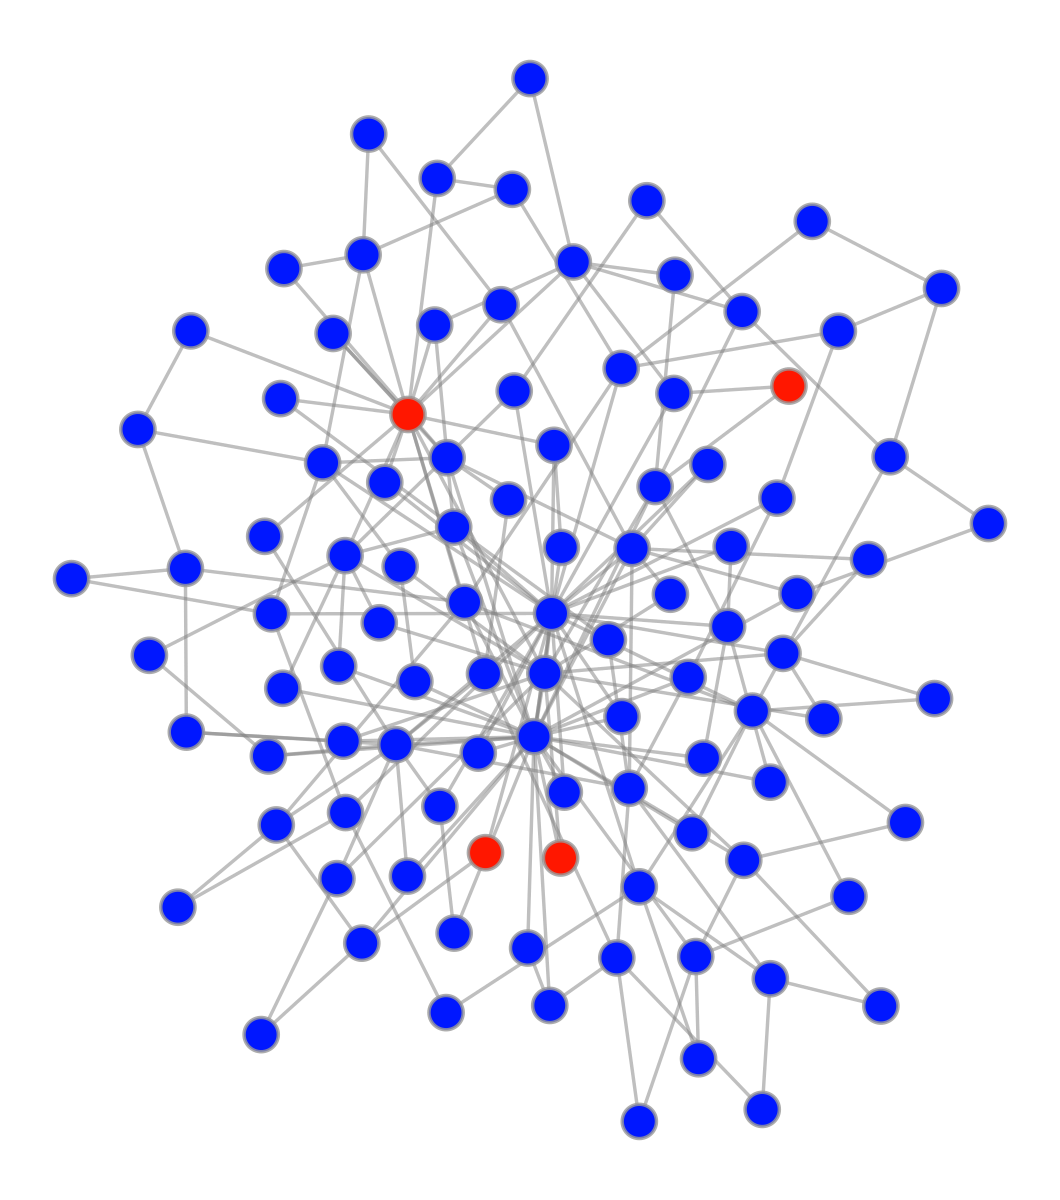

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9eea9a4670, at 0x7f9ee5f9d730>

In [14]:
# Code to draw the network

# This code is to color the vertices of our graph

cmap = cm.get_cmap('gist_rainbow') # Color map
color_sampled_vertices = cmap(0.05) # Red
color_others = cmap(0.75) # Blue

colors_vertices = []
for k in g.get_vertices():
    if k in S:
        colors_vertices.append(color_sampled_vertices)
    else:
        colors_vertices.append(color_others)

# This code is to color the edges of our graph
edge_color = [0.5, 0.5, 0.5, 0.5] # Grey

# This code draws the graph
gt.graph_draw(g, vprops={'fill_color': g.new_vertex_property('vector<float>', vals=colors_vertices)}, eprops={'color': g.new_edge_property('vector<float>', val=edge_color)})

### STEP 2: COMPUTE THE MEETING TIME OF THE RANDOM WALKS STARTED AT EACH PAIR OF SAMPLED VERTICES

We compute samples of the meeting time of the random walk started at i and the random walks started at j for every two element subset (i,j) of the set S. In other words, for every pair of vertices such that both are in S we compute the meeting time of the random walks started at these vertices. \
For example if S = {1,2,3} we compute the meeting time of the random walks started at (1,2), (2,3) and (1,3)

In [15]:
# Initialize a RandomWalkSimulator on the network g
rws = RandomWalkSimulator(g=g)

The code below is very similar to that used in the first example. Indeed we are doing exactly the same thing just with more vertices. \
Basically, this example illustrates how the code to compute the RSE distance for one pair of vertices can be used to compute the RSE distance between many pairs of vertices. \
As before, in order to compute the samples of the meeting times of the random walk started at i and the random walk started at j for every pair of vertices i, j in S we need to feed the following information to the method **get_meeting_times_rse_dist** of the RandomWalkSimulator:
* The vertices for which we want to compute meeting time samples, in this case the vertices in the set S
* The number of samples of the meeting time we want the method to return per vertex. The more samples the more accurate will our estimate of the average meeting time be. 
* The maximum number of steps for which we want to simulate the random walks in order to get one sample of the meeting time. The simulation will stop after running for this number of time steps. It could stop earlier if all the walks meet in less time steps.

With these parameters we can launch the method **get_meeting_times_rse_dist**. This method returns us a dictionary with keys being pairs of vertices and values being an array with samples of the meeting time between those two vertices.

In [16]:
# The vertices for which we to compute the samples
vertices = S

# The number of samples of the meeting per pair of vertices
n_samples_per_vertex = 50

# The maximum number of steps for which we want the simulation to run 
max_time_steps = 1000

# We call the method get_meeting_times of the random walks simulator with the above parameters
meeting_times = rws.get_meeting_times_rse_dist(max_time_steps=max_time_steps, vertices=vertices, n_samples_per_vertex=n_samples_per_vertex)

# We display the meeting time dictionary (see the remarks below)
meeting_times

 58%|█████▊    | 579/999 [00:00<00:00, 771.34it/s]


{(10, 88): array([ 80., 173.,  44., ...,  45., 108., 149.]),
 (10, 93): array([73., 62., 14., ..., 38.,  4., 43.]),
 (10, 84): array([ 14., 127.,  26., ...,  26.,  73.,  10.]),
 (88, 10): array([ 80., 106.,  63., ...,  28.,  56., 149.]),
 (88, 93): array([  9., 117.,  36., ...,  56.,  56.,  24.]),
 (88, 84): array([127.,  63., 186., ..., 114.,  70., 152.]),
 (93, 10): array([73.,  8., 73., ..., 71., 40., 43.]),
 (93, 88): array([ 9., 23., 21., ..., 67., 72., 24.]),
 (93, 84): array([125.,  89.,  47., ...,  65.,  32.,  26.]),
 (84, 10): array([ 14.,  69.,  27., ..., 127.,  13.,  10.]),
 (84, 88): array([127.,  33.,  80., ...,  41., 133., 152.]),
 (84, 93): array([125.,  60.,   7., ...,  23.,  26.,  26.])}

Some remarks on the dictionary meeting_times:
* It is a dictionary where the keys are pairs of vertices and the values are arrays containing samples of the meeting times of the walks started at that pair of vertices
* Occasionaly you might see an entry equal to -1 in the array. This happens when the walks corresponding to one sample did not meet within mex_time_steps. See below for comments on this issue

In case you have some -1 in the meeting_time array you can adopt the same approach as in example 1. \
Namely, either you rerun the simulation incerasing the max_time_steps or use the MeetingTimeEstimator as illustated below.

In [17]:
# Go through the meeting times and estimate the meeting time for the samples in which the walks did not meet within max_time_steps
meeting_times_with_estimates = {}
for ij in meeting_times:
    mt_ij = meeting_times[ij]
    mt_ij_estimate = MeetingTimeEstimator.estimate_meeting_times_unmet_random_walks(meeting_times=mt_ij, max_time_steps=max_time_steps)
    meeting_times_with_estimates[ij] = mt_ij_estimate

# Display the meeting times with the new estimates
meeting_times_with_estimates

{(10, 88): array([ 80., 173.,  44., ...,  45., 108., 149.]),
 (10, 93): array([73., 62., 14., ..., 38.,  4., 43.]),
 (10, 84): array([ 14., 127.,  26., ...,  26.,  73.,  10.]),
 (88, 10): array([ 80., 106.,  63., ...,  28.,  56., 149.]),
 (88, 93): array([  9., 117.,  36., ...,  56.,  56.,  24.]),
 (88, 84): array([127.,  63., 186., ..., 114.,  70., 152.]),
 (93, 10): array([73.,  8., 73., ..., 71., 40., 43.]),
 (93, 88): array([ 9., 23., 21., ..., 67., 72., 24.]),
 (93, 84): array([125.,  89.,  47., ...,  65.,  32.,  26.]),
 (84, 10): array([ 14.,  69.,  27., ..., 127.,  13.,  10.]),
 (84, 88): array([127.,  33.,  80., ...,  41., 133., 152.]),
 (84, 93): array([125.,  60.,   7., ...,  23.,  26.,  26.])}

### STEP 3: COMPUTE THE RSE DISTANCES

We compute the RSE distance between i and j for every pair i,j such that i and j are in S. \
For this we simply iterate through meeting_times_with_estimates and for each pair we compute the mean and std of the meeting times of that pair.

In [18]:
# We compute the RSE distance and the standard deviation for every pair of vertice i and j 
rse_distances = {}
for ij in meeting_times_with_estimates:
    mt_ij = meeting_times_with_estimates[ij]
    rse_distances[ij] = (np.mean(mt_ij), np.std(mt_ij))

Finally, we print out the results

In [19]:
# We print our results
for ij in rse_distances:
    rse_dist_ij = rse_distances[ij][0]
    std_rse_dist_ij = rse_distances[ij][1]
    print('The RSE distance between', ij[0], 'and', ij[1], 'is', rse_dist_ij, 'with 95 percent confidence intervals of size', 1.96*std_rse_dist_ij/np.sqrt(n_samples_per_vertex))

The RSE distance between 10 and 88 is 64.4744 with 95 percent confidence intervals of size 16.609301696657223
The RSE distance between 10 and 93 is 61.1472 with 95 percent confidence intervals of size 16.056490188348047
The RSE distance between 10 and 84 is 57.6432 with 95 percent confidence intervals of size 16.512249585049528
The RSE distance between 88 and 10 is 64.4744 with 95 percent confidence intervals of size 16.609301696657223
The RSE distance between 88 and 93 is 63.312 with 95 percent confidence intervals of size 16.664058448919096
The RSE distance between 88 and 84 is 64.02 with 95 percent confidence intervals of size 17.536792853974184
The RSE distance between 93 and 10 is 61.1472 with 95 percent confidence intervals of size 16.056490188348047
The RSE distance between 93 and 88 is 63.312 with 95 percent confidence intervals of size 16.664058448919096
The RSE distance between 93 and 84 is 58.6264 with 95 percent confidence intervals of size 15.871749432416367
The RSE distan

## EXAMPLE 3: COMPUTING DELTA(G)

In this example we compute the value of the structural diversity index Delta(G) of a network

### STEP 1: COMPUTE MEETING TIME OF RANDOMLY STARTED WALKS ON A NETWORK
We compute samples of the meeting time for randomly started walks on the network. As a network we use the same network g as in the previous examples.

Here is a visualizaiton of the network

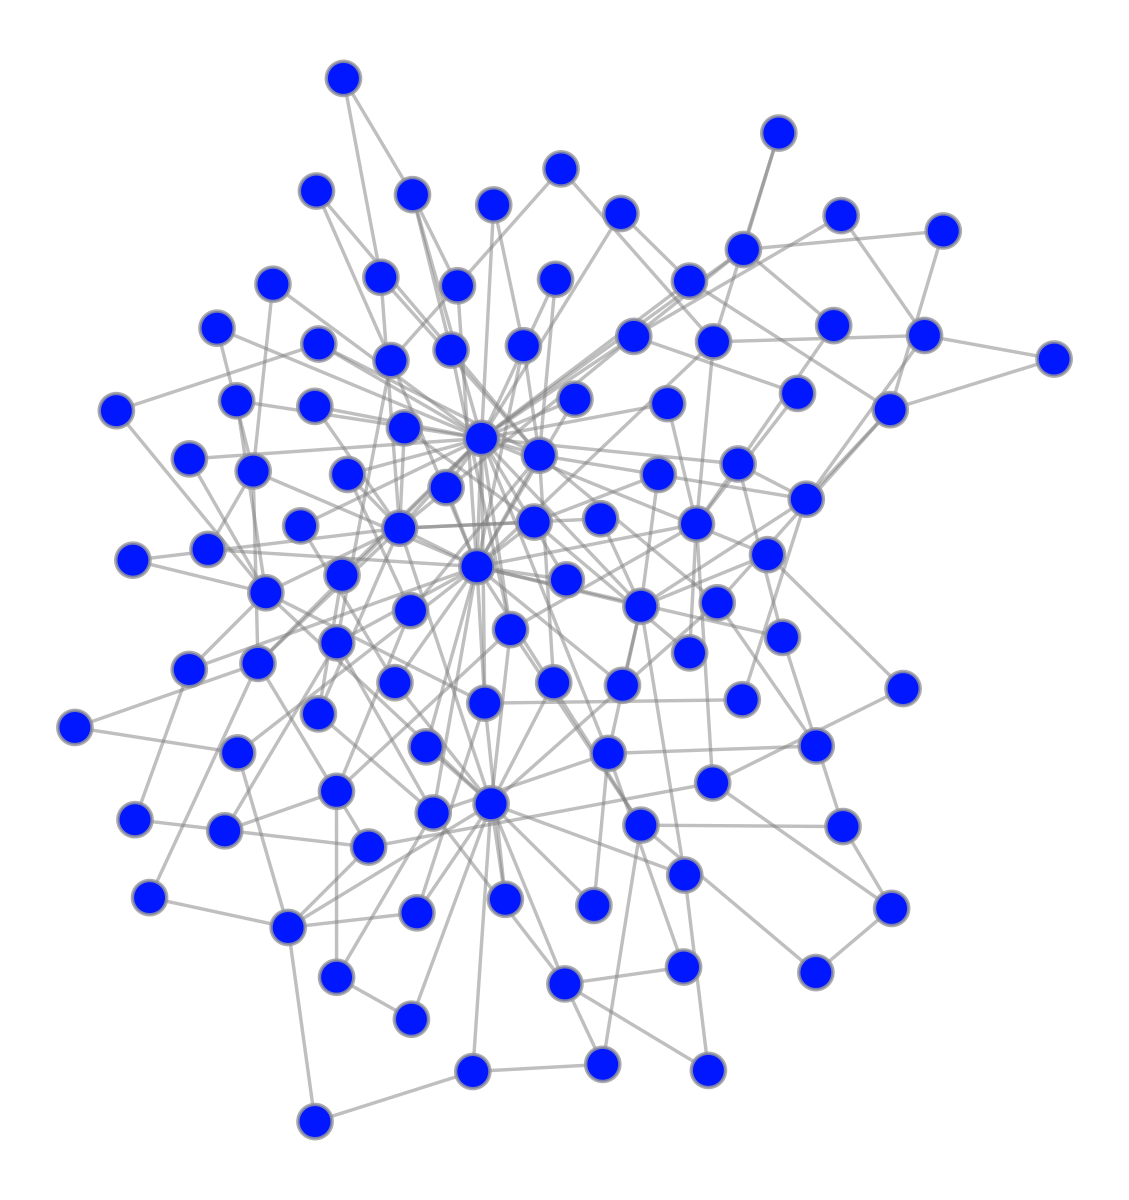

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9eea9a4670, at 0x7f9eea992dc0>

In [20]:
# This code is to color the vertices of our graph
cmap = cm.get_cmap('gist_rainbow') # Color map
color_vertices = cmap(0.75) # Blue

# Color for edges
edge_color = [0.5, 0.5, 0.5, 0.5] # Grey

# Draw the graph
gt.graph_draw(g, vprops={'fill_color': g.new_vertex_property('vector<float>', val=color_vertices)}, eprops={'color': g.new_edge_property('vector<float>', val=edge_color)})

Now we compute the samples of the meeting time of randomly started walks

In [21]:
# Initialize a RandomWalkSimulator on the network g
rws = RandomWalkSimulator(g=g)

In order to compute samples of the meeting time of the randomly started walks we need to feed the following information to the method **get_meeting_times_delta_g** of the RandomWalkSimulator:
* The number of samples of the meeting time we want the method to return. The more samples the more accurate will our estimate of the Delta(G) be accurate
* The maximum number of steps for which we want to simulatation to run. The simulation will stop after running for this number of time steps. It could stop earlier if all the randomly started walks we are simulating meet before. 

With these parameters we can launch the method **get_meeting_times_rse_dist**. This method returns us an array (no need to have a dictionary) with samples of the meeting time of the randomly started walks.


In [22]:
# The number of samples of the meeting time we wantl.
n_samples = 50

# The maximum number of steps for which we want to run the simulation.
max_time_steps = 1000

# We call the method get_meeting_times_delta_g of the random walks simulator with the above parameters
meeting_times = rws.get_meeting_times_delta_g(max_time_steps=max_time_steps, n_samples=n_samples)

# We display the meeting time array (see the remarks below)
meeting_times

 50%|█████     | 503/999 [00:00<00:00, 1639.15it/s]


array([ 86.,  30.,  47., ..., 232.,  78.,   0.])

Again, as in the previous example you could have the issue that some samples are equal to -1 because the randomly started walks used to compute that sample did not meet within max_time_steps.
To remove these -1s you can adopt two approaches: 
* Rereun the method get_meeting_times_delta_g with a larger max_time_steps and hope that the walks for all samples meet. 
* Use the class MeetingTimeEstimator. This class, as illustrated above, is usefull to estimate the value of sample meeting time for which the walks did not meet. 

Here we adopt this second approach

In [23]:
# Use the estimator to estimate the meeting time of the walks that did not meet.
# Essentially this replaces the -1 by an estimate of what the value should be.
meeting_times_estimate = MeetingTimeEstimator.estimate_meeting_times_unmet_random_walks(meeting_times=meeting_times, max_time_steps=max_time_steps)
meeting_times_estimate

array([ 86.,  30.,  47., ..., 232.,  78.,   0.])

### STEP 2: COMPUTE DELTA(G)
We compute Delta(G) for the network g displayed above. Recall that Delta(G) is just the average meeting time of randomly started walks on the network G divided by the size of the network G.

In [24]:
# Average value of the meeting time of randomly started walks on the network G
avg_meeting_time = np.mean(meeting_times_ij_estimate)
network_size = g.num_vertices()
delta_g = avg_meeting_time/network_size

# The standard deviation of the meeting times for the confidence intervals 
std_meeting_times = np.std(meeting_times_estimate/network_size)

Finally, the results:

In [25]:
print('For the network g above we have that Delta(G) =', delta_g, 'with 95 percent confidence intervals of size', 1.96*std_meeting_times/np.sqrt(n_samples))

For the network g above we have that Delta(G) = 0.5986319999999999 with 95 percent confidence intervals of size 0.15881739752481516


Hope you enjoyed this tutorial!